# EDA
Task: find best permutations for sequences that get the lowest perplexity, based on gemini model

In [1]:
import gc
import os
from math import exp
from collections import Counter
from typing import List, Union

import numpy as np
import pandas as pd
import transformers
import torch

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
PAD_TOKEN_LABEL_ID = torch.nn.CrossEntropyLoss().ignore_index
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from metric import PerplexityCalculator
scorer = PerplexityCalculator('/kaggle/input/gemma-2/transformers/gemma-2-9b/2')

In [2]:
df = pd.read_csv('/kaggle/input/santa-2024/sample_submission.csv')

In [3]:
df

,id,text
0,0,advent chimney elf family fireplace gingerbrea...
1,1,advent chimney elf family fireplace gingerbrea...
2,2,yuletide decorations gifts cheer holiday carol...
3,3,yuletide decorations gifts cheer holiday carol...
4,4,hohoho candle poinsettia snowglobe peppermint ...
5,5,advent chimney elf family fireplace gingerbrea...


We have 5 rows, each with words from Cristmas stories, that we need to rearrange in correct order

In [4]:
df['text'].apply(lambda x: len(x.split()))

0     10
1     20
2     20
3     30
4     50
5    100
Name: text, dtype: int64

We have stories from 10 to 100 words

In [5]:
Counter((df['text'][0]).split())

Counter({'advent': 1,
         'chimney': 1,
         'elf': 1,
         'family': 1,
         'fireplace': 1,
         'gingerbread': 1,
         'mistletoe': 1,
         'ornament': 1,
         'reindeer': 1,
         'scrooge': 1})

In [6]:
all_words = df['text'].sum().split()
unique_words = list(set(all_words))
print('all words', len(all_words), 'unique words', len(unique_words))

all words 225 unique words 94


In [7]:
df['cnt'] = df['text'].apply(lambda x: Counter(x.split()))

In [8]:
for k in range(6):
    num_intersections_k = []
    for i in range(6):
        if i == k:
            num_intersections_k.append(-1)
        else:
            intersection = df['cnt'][0] & df['cnt'][i]
            num_intersections = sum(intersection.values())
            num_intersections_k.append(num_intersections)
    df[f'intersect_{k}'] = num_intersections_k

In [9]:
df

,id,text,cnt,intersect_0,intersect_1,intersect_2,intersect_3,intersect_4,intersect_5
0,0,advent chimney elf family fireplace gingerbrea...,"{'advent': 1, 'chimney': 1, 'elf': 1, 'family'...",-1,10,10,10,10,10
1,1,advent chimney elf family fireplace gingerbrea...,"{'advent': 1, 'chimney': 1, 'elf': 1, 'family'...",10,-1,10,10,10,10
2,2,yuletide decorations gifts cheer holiday carol...,"{'yuletide': 1, 'decorations': 1, 'gifts': 1, ...",2,2,-1,2,2,2
3,3,yuletide decorations gifts cheer holiday carol...,"{'yuletide': 1, 'decorations': 1, 'gifts': 1, ...",2,2,2,-1,2,2
4,4,hohoho candle poinsettia snowglobe peppermint ...,"{'hohoho': 1, 'candle': 1, 'poinsettia': 1, 's...",1,1,1,1,-1,1
5,5,advent chimney elf family fireplace gingerbrea...,"{'advent': 1, 'chimney': 2, 'elf': 1, 'family'...",10,10,10,10,10,-1


Text 1 includes Text 0. Text 3 includes Text 2. Text 5 includes all texts and is the most comprehensive.   
However, this describes the inclusion of text sets. The actual vocabulary in each text might differ, as a text can include another while still having unique words of its own.

In [12]:
scorer = PerplexityCalculator(
    model_path='/kaggle/input/gemma-2/transformers/gemma-2-9b/2',
    load_in_8bit=False,
) 

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [13]:
def get_embeddings(
    self, input_texts: Union[str, List[str]], debug=False
) -> Union[torch.Tensor, List[torch.Tensor]]:
    """
    Computes embeddings for given texts.

    Parameters
    ----------
    input_texts : str or list of str
        A single string or a list of strings.
    debug : bool, default=False
        Print debugging information.

    Returns
    -------
    torch.Tensor or list of torch.Tensor
        Embeddings for the input texts.
    """
    single_input = isinstance(input_texts, str)
    input_texts = [input_texts] if single_input else input_texts

    embeddings_list = []
    with torch.no_grad():
        for text in input_texts:
            #text_with_special = f"{self.tokenizer.bos_token}{text}{self.tokenizer.eos_token}"
            
            text_with_special = text
            
            # Tokenize
            model_inputs = self.tokenizer(
                text_with_special,
                return_tensors='pt',
                add_special_tokens=False,
            )

            if 'token_type_ids' in model_inputs:
                model_inputs.pop('token_type_ids')

            model_inputs = {k: v.to(DEVICE) for k, v in model_inputs.items()}

            # Compute embeddings
            embeddings = self.model.get_input_embeddings()(model_inputs['input_ids'])
            embeddings_list.append(embeddings.cpu())

            if debug:
                print(f"Embeddings for '{text}': {embeddings}")

    return embeddings_list[0] if single_input else embeddings_list

In [17]:
corpus = [text.split() for text in df["text"]]
unique_words = list(set(word for text in corpus for word in text))


embedding_words = {}
words_info = []

for word in unique_words:
    outputs = get_embeddings(scorer, word)
    
    if outputs.shape[1] != 1:
        words_info.append({
            "word": word,
            "embedding_shape": str(outputs.shape)
        })
    
    embedding_words[word] = outputs.mean(axis=(0, 1))

pd.DataFrame(words_info).head()

,word,embedding_shape
0,poinsettia,"torch.Size([1, 3, 3584])"
1,wreath,"torch.Size([1, 2, 3584])"
2,stocking,"torch.Size([1, 2, 3584])"
3,scrooge,"torch.Size([1, 3, 3584])"
4,fruitcake,"torch.Size([1, 2, 3584])"


In [22]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.7 MB/s eta 0:00:00


In [25]:
import umap
import matplotlib.pyplot as plt
def umap_visualize(words, embedding_words, highlight_words=[]):
    data = [embedding_words[word] for word in words]
    data = torch.stack(data).numpy()
    
    reducer = umap.UMAP(n_components=2, random_state=42)
    reduced_data = reducer.fit_transform(data)
    
    plt.figure(figsize=(12, 8))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='blue')
    
    for i, word in enumerate(words):
        if word in highlight_words:
            plt.scatter(reduced_data[i, 0], reduced_data[i, 1], c='orange')
        plt.annotate(word, (reduced_data[i, 0], reduced_data[i, 1]))
    
    for i in range(len(highlight_words) - 1):
        start_idx = words.index(highlight_words[i])
        end_idx = words.index(highlight_words[i + 1])
        plt.arrow(reduced_data[start_idx, 0], reduced_data[start_idx, 1],
                  reduced_data[end_idx, 0] - reduced_data[start_idx, 0],
                  reduced_data[end_idx, 1] - reduced_data[start_idx, 1],
                  color='red', head_width=0.05, length_includes_head=True)
    
    plt.title('2D Visualization of 3584-D Vectors using UMAP')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


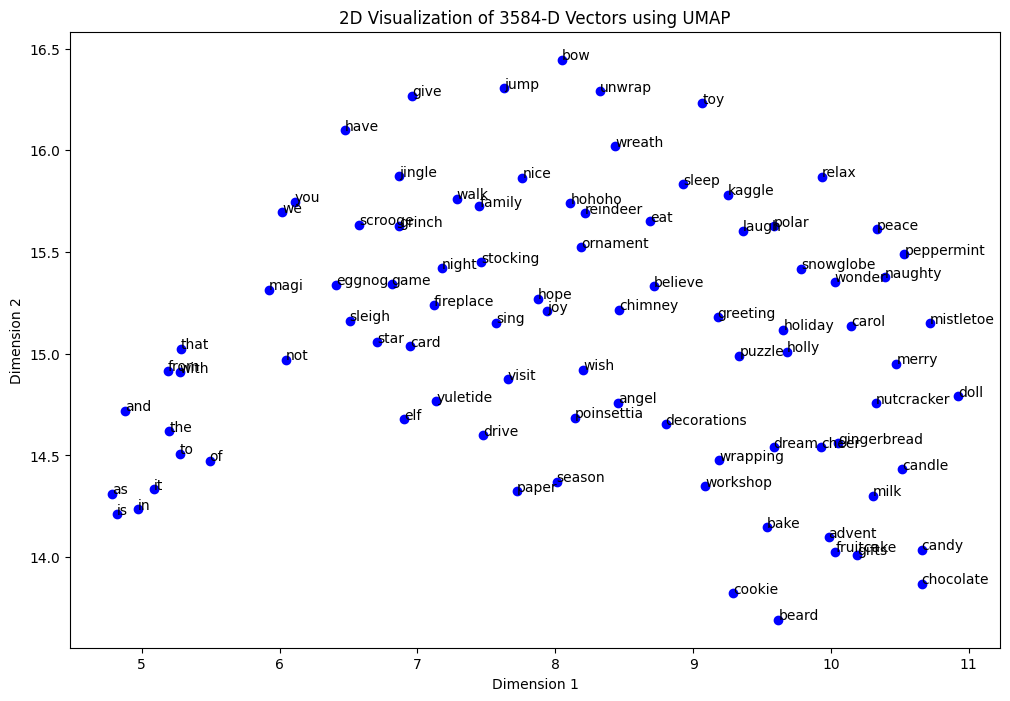

In [26]:
umap_visualize(unique_words, embedding_words)

We can see different clusters with prepsitions (left), christams theme words (right), verbs (up). Seems that we can try take words from each cluster, not repeated

Let's look on the first sample words:

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


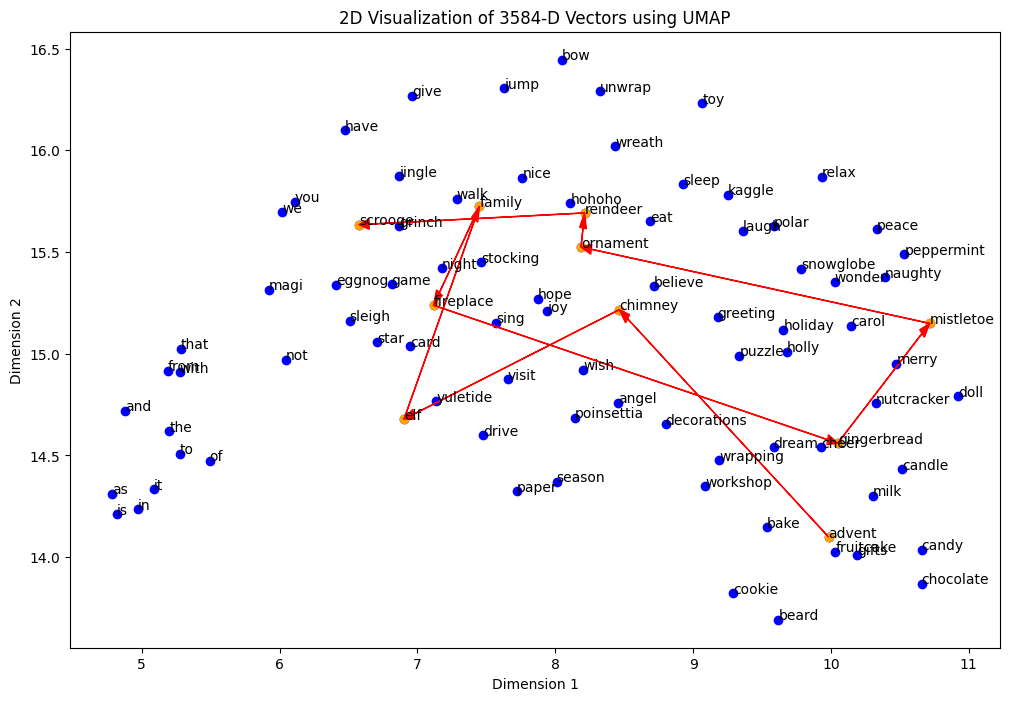

In [30]:
umap_visualize(unique_words, embedding_words, df['text'][0].split())

As we suggested that we need to use diversity of words from different clusters together